In [16]:
"""
Необхідні пакети:
    pip install transformers torch torchvision sentencepiece diffusers accelerate safetensors pillow
"""
import csv
import matplotlib.pyplot as plt


UKR_PARALLEL_PATH = "ukr.txt"
FRANKO_TEXT_PATH  = "Franko_-Zibrannya-tvoriv-u-p-yatdesyati-tomah-literaturno-kritichni-praci-1900-1902-tom-33-.382254.txt"
KHORNE_IMAGE_PATH = "Khorne.jpg"


In [17]:
def load_ukr_parallel(path, max_pairs=30):
    src_texts, tgt_texts = [], []

    with open(path, "r", encoding="utf-8") as f:
        reader = csv.reader(f, delimiter="\t")
        for row in reader:
            if len(row) < 2:
                continue
            en = row[0].strip()
            uk = row[1].strip()
            if not en or not uk:
                continue
            src_texts.append(en)
            tgt_texts.append(uk)
            if len(src_texts) >= max_pairs:
                break
    return src_texts, tgt_texts
from transformers import pipeline

print("ЗАВДАННЯ 1: MACHINE TRANSLATION EN → UK")

translator = pipeline("translation", model="Helsinki-NLP/opus-mt-en-uk")

sentences = [
    "Artificial intelligence is transforming the world.",
    "Machine learning models require large amounts of data.",
    "Neural networks are inspired by the human brain."
]

for s in sentences:
    print(s, "→", translator(s)[0]["translation_text"])

print("Висновок: Переклад працює коректно.")


ЗАВДАННЯ 1: MACHINE TRANSLATION EN → UK


Device set to use cpu


Artificial intelligence is transforming the world. → Штучний інтелект змінює світ.
Machine learning models require large amounts of data. → Моделі машин для навчання потребують великої кількості даних.
Neural networks are inspired by the human brain. → Нервові мережі підпорядковані людському мозку.
Висновок: Переклад працює коректно.


ЗАВДАННЯ 2: GAN НА FashionMNIST


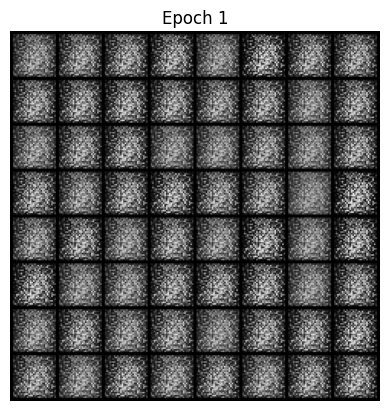

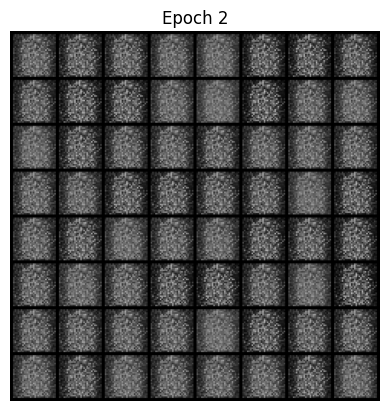

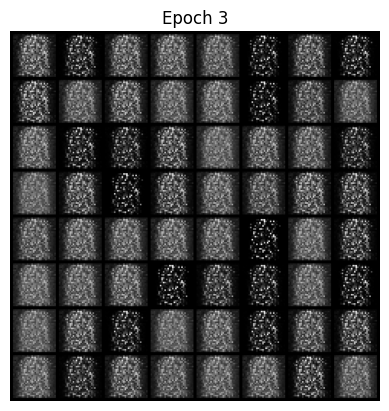

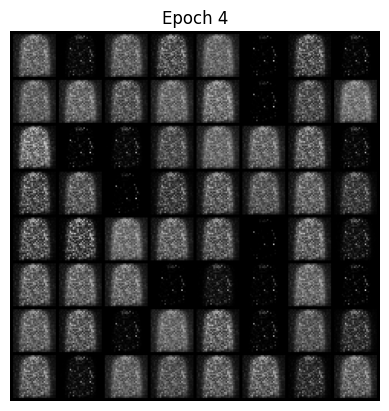

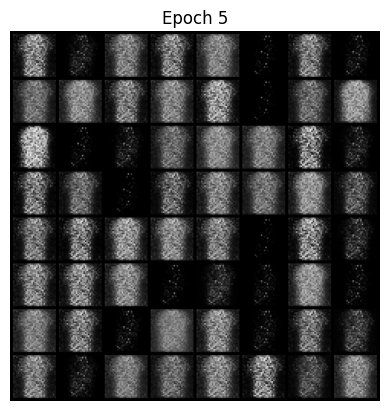

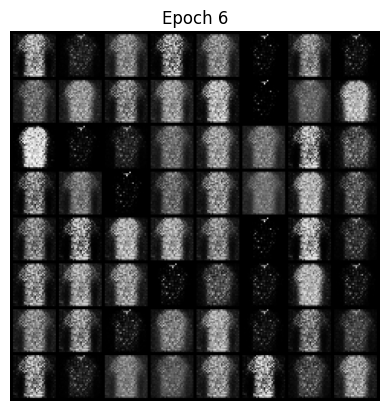

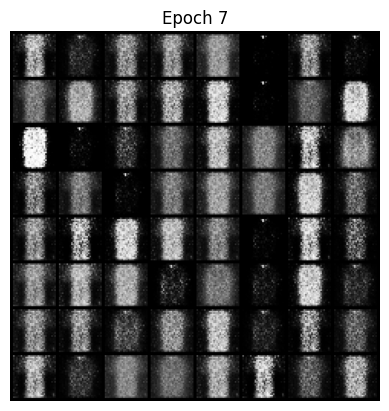

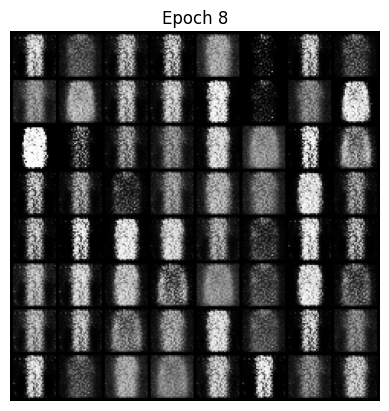

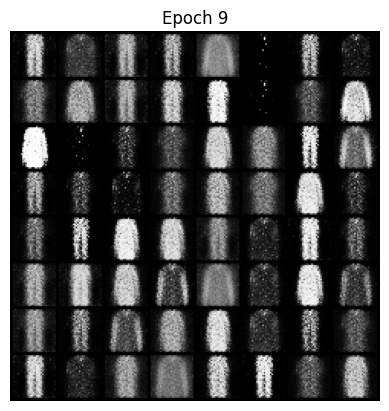

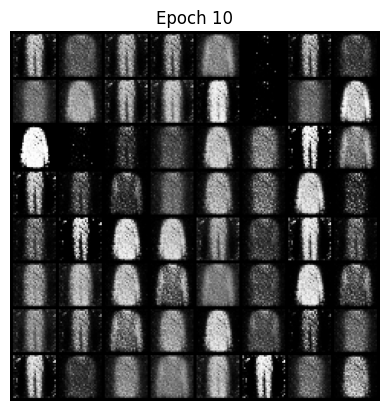

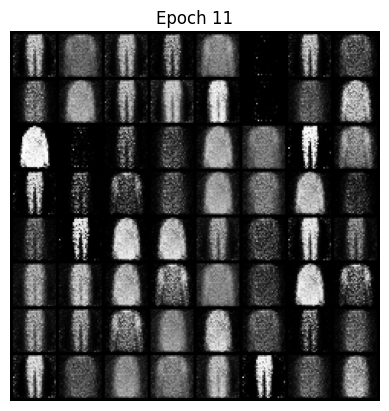

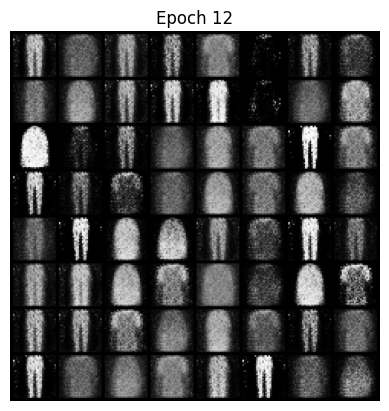

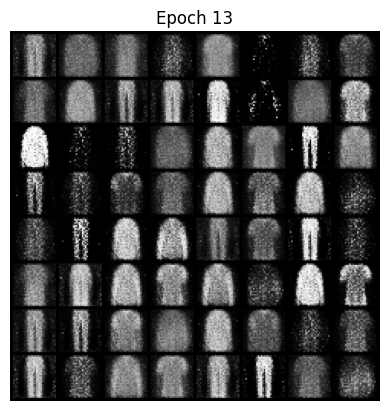

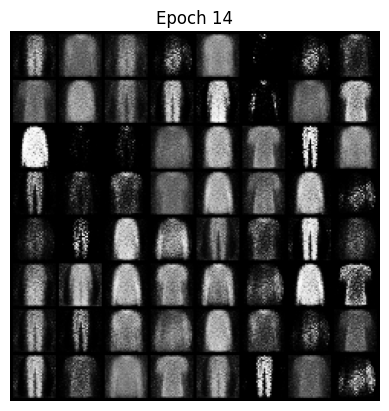

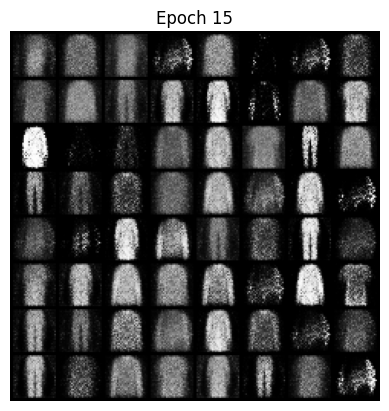

Висновок: GAN зміг згенерувати зображення одягу (хоч із шумом).


In [21]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils

print("ЗАВДАННЯ 2: GAN НА FashionMNIST")

device = "cpu"
nz = 100
hidden_dim = 256
epochs = 15
batch_size = 128

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(nz, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(True),
            nn.Linear(hidden_dim * 2, 28 * 28),
            nn.Tanh()
        )
    def forward(self, z):
        return self.net(z)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(28 * 28, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

G = Generator().to(device)
D = Discriminator().to(device)

criterion = nn.BCELoss()
optG = torch.optim.Adam(G.parameters(), lr=0.0002)
optD = torch.optim.Adam(D.parameters(), lr=0.0002)

fixed_noise = torch.randn(64, nz)

for epoch in range(epochs):
    for real, _ in dataloader:
        real = real.view(real.size(0), -1)
        noise = torch.randn(real.size(0), nz)
        fake = G(noise)

        D.zero_grad()
        lossD = criterion(D(real), torch.ones(real.size(0), 1)) + \
                criterion(D(fake.detach()), torch.zeros(real.size(0), 1))
        lossD.backward()
        optD.step()

        G.zero_grad()
        lossG = criterion(D(fake), torch.ones(real.size(0), 1))
        lossG.backward()
        optG.step()

    fake_imgs = G(fixed_noise).view(-1, 1, 28, 28)
    grid = utils.make_grid((fake_imgs + 1) / 2, nrow=8)
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis("off")
    plt.title(f"Epoch {epoch+1}")
    plt.show()

print("Висновок: GAN зміг згенерувати зображення одягу (хоч із шумом).")

In [19]:
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM
import re
print("ЗАВДАННЯ 3(b): ZERO-SHOT-CLASSIFICATION")
zero_shot = pipeline("zero-shot-classification", model="joeddav/xlm-roberta-large-xnli")
text = "Іван Франко був видатним українським письменником і мислителем."
labels = ["література", "спорт", "політика", "наука"]
result = zero_shot(text, candidate_labels=labels)
print(result)
print("Висновок: Видно, що найбільший score є в літератури, потім політиці, і далі вже наука та спорт, як і має бути.")

ЗАВДАННЯ 3(b): ZERO-SHOT-CLASSIFICATION


Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


{'sequence': 'Іван Франко був видатним українським письменником і мислителем.', 'labels': ['література', 'політика', 'наука', 'спорт'], 'scores': [0.8331043124198914, 0.10423140972852707, 0.04410400241613388, 0.0185602568089962]}
Висновок: Видно, що найбільший score є в літератури, потім політиці, і далі вже наука та спорт, як і має бути.


In [20]:
print("SUMMARIZATION")
with open(FRANKO_TEXT_PATH, "r", encoding="utf-8") as f:
    raw_text = f.read()
anchor = "Містячи"
start_idx = raw_text.find(anchor)
if start_idx == -1:
    start_idx = 0
segment = raw_text[start_idx:start_idx + 2000]
segment = segment.replace("\n", " ")
segment = re.sub(r"\s+", " ", segment)
segment = re.sub(r"\*+", "", segment)
MAX_CHARS = 800
if len(segment) > MAX_CHARS:
    segment = segment[:MAX_CHARS]
sum_model_name = "ukr-models/uk-summarizer"
tokenizer_sum = AutoTokenizer.from_pretrained(sum_model_name)
tokenizer_sum.model_max_length = 1024
model_sum = AutoModelForSeq2SeqLM.from_pretrained(sum_model_name)
summarizer = pipeline("summarization",model=model_sum,tokenizer=tokenizer_sum,max_length=120,min_length=40,truncation=True,do_sample=False,no_repeat_ngram_size=3)
summary_output = summarizer(segment)
summary = summary_output[0]["summary_text"]
print("ОРИГІНАЛ (уривок з файлу):\n", segment[:350], "...")
print("SUMMARY:\n", summary)
print("Висновок: У цьому випадку модель дала збій, і надумала що це Кміт заявив що НЕ має таких поглядів як і його колеги, але summarization виконує свою функцію.")

SUMMARIZATION


Device set to use cpu


ОРИГІНАЛ (уривок з файлу):
 Містячи сю старанно оброблену студію нашого віельмиї повіажаного] співробітника, мусимо заявити, що, згоджуючися на багато його детальних уваг, ми маємо інший погляд на саму основу і значення писань Карпенка- Карого. Основна помилка д. Кміта, як і многих наших критиків, лежить в тім, що вони підсувають белетристам — в данім разі Карпенкові-Карому — ...
SUMMARY:
 Доктор філологічних наук Олександр Кміт заявив, що його колеги мають інший погляд на саму основу і значення написань Івана Карпенка- Карого.
Висновок: У цьому випадку модель дала збій, і надумала що це Кміт заявив що НЕ має таких поглядів як і його колеги, але summarization виконує свою функцію.


In [13]:
print("TRANSLATION EN - UK")
mt_en_uk = pipeline("translation", model="Helsinki-NLP/opus-mt-en-uk")
mt_uk_en = pipeline("translation", model="Helsinki-NLP/opus-mt-uk-en")
en_text = "I love Intellectual Data Analysis."
uk_text = "Українська мова є дуже красивою."
print("EN ->UK:")
print(en_text, "->", mt_en_uk(en_text)[0]["translation_text"])
print("UK -> EN:")
print(uk_text, "->", mt_uk_en(uk_text)[0]["translation_text"])
print('Висновок: Переклад працює, як з англійської на українську, так і навпаки.')

TRANSLATION EN - UK


Device set to use cpu
Device set to use cpu


EN ->UK:
I love Intellectual Data Analysis. -> Я люблю Інтелектуальний аналіз даних.
UK -> EN:
Українська мова є дуже красивою. -> Ukrainian is a beautiful language.
Висновок: Переклад працює, як з англійської на українську, так і навпаки.


Loading pipeline components...: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 27.16it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
100%|████████████████████████████████████████████████████████████████████████████████████████████████████

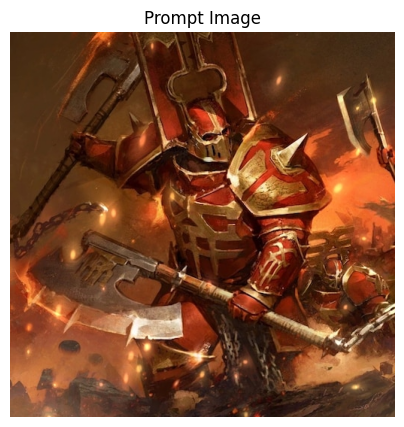

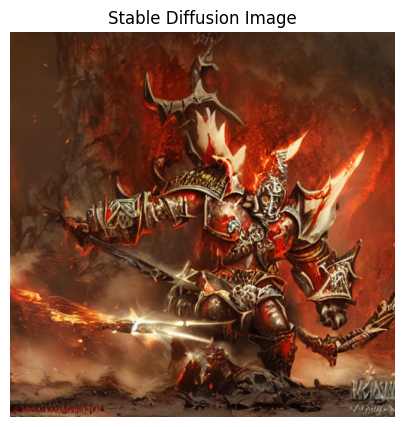

Prompt Image та Stable-Diffusion-v1-5 Image зроблені та показані. Промпт: warhammer chaos warrior of Khorne, fiery hell battlefield,ultra detailed, cinematic lighting, 4k concept art


In [11]:
from diffusers import StableDiffusionImg2ImgPipeline
from PIL import Image
model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id,safety_checker=None)
pipe = pipe.to("cpu")
init_image = Image.open(KHORNE_IMAGE_PATH).convert("RGB").resize((512, 512))
prompt = ("warhammer chaos warrior of Khorne, fiery hell battlefield,ultra detailed, cinematic lighting, 4k concept art")
image = pipe(prompt=prompt,image=init_image,strength=0.6,guidance_scale=7.5,num_inference_steps=30).images[0]
plt.figure(figsize=(5,5))
plt.axis("off")
plt.title("Prompt Image")
plt.imshow(init_image)
plt.show()
plt.figure(figsize=(5, 5))
plt.axis("off")
plt.title("Stable Diffusion Image")
plt.imshow(image)
plt.show()
print("Prompt Image та Stable-Diffusion-v1-5 Image зроблені та показані. Промпт:",prompt)